2023-03-09 15:43:53.475681: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 15:43:53.649704: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-09 15:43:53.649728: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-09 15:43:54.623186: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Epoch 1/10
67/67 [==============================] - 15s 157ms/step - loss: 0.7798 - accuracy: 0.7825 - val_loss: 0.5137 - val_accuracy: 0.8224
Epoch 2/10
67/67 [==============================] - 8s 115ms/step - loss: 0.4212 - accuracy: 0.8714 - val_loss: 0.3117 - val_accuracy: 0.9174
Epoch 3/10
67/67 [==============================] - 8s 121ms/step - loss: 0.1641 - accuracy: 0.9590 - val_loss: 0.1301 - val_accuracy: 0.9751
Epoch 4/10
67/67 [==============================] - 11s 164ms/step - loss: 0.0543 - accuracy: 0.9878 - val_loss: 0.1000 - val_accuracy: 0.9858
Epoch 5/10
67/67 [==============================] - 7s 111ms/step - loss: 0.0285 - accuracy: 0.9932 - val_loss: 0.1004 - val_accuracy: 0.9877
Epoch 6/10
67/67 [==============================] - 7s 109ms/step - loss: 0.0206 - accuracy: 0.9950 - val_loss: 0.1025 - val_accuracy: 0.9884
Epoch 7/10
67/67 [==============================] - 7s 111ms/step - loss: 0.0169 - accuracy: 0.9956 - val_loss: 0.1060 - val_accuracy: 0.9888
Epoc

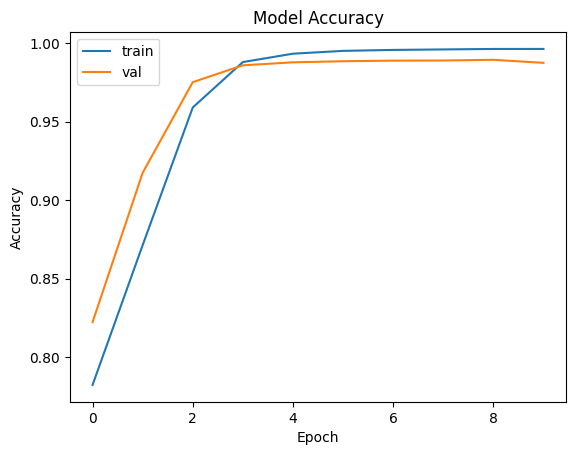

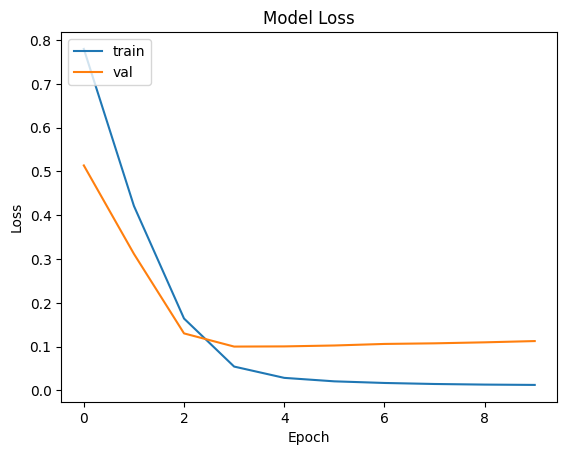

In [1]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, TimeDistributed, Dense
from keras.utils import to_categorical
import gensim.models as gm
import nltk
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from sklearn.model_selection import GridSearchCV
import keras
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
import conllu
import torch
import onnx


# Read the CoNLL-U file
data_file = open("./UD_English-Atis/en_atis-ud-train.conllu", "r", encoding="utf-8")
data = conllu.parse(data_file.read())

val_file = open("./UD_English-Atis/en_atis-ud-dev.conllu", "r", encoding="utf-8")
val = conllu.parse(val_file.read())

test_file = open("./UD_English-Atis/en_atis-ud-test.conllu", "r", encoding="utf-8")
test = conllu.parse(test_file.read())

# Extract the features and labels
X_train = []
y_train = []
tags = set([])
for sentence in data:
    sentence_words = []
    sentence_labels = []
    for token in sentence:
        tags.add(token["upos"])
        sentence_words.append(token["form"])
        sentence_labels.append(token["upos"])
    X_train.append(sentence_words)
    y_train.append(sentence_labels)

X_val = []
y_val = []
for sentence in val:
    sentence_words = []
    sentence_labels = []
    for token in sentence:
        sentence_words.append(token["form"])
        sentence_labels.append(token["upos"])
    X_val.append(sentence_words)
    y_val.append(sentence_labels)

X_test = []
y_test = []
for sentence in test:
    sentence_words = []
    sentence_labels = []
    for token in sentence:
        sentence_words.append(token["form"])
        sentence_labels.append(token["upos"])
    X_test.append(sentence_words)
    y_test.append(sentence_labels)


all_words = []
for words in X_train:
    all_words.extend(words)
freq_dist = nltk.FreqDist(all_words)
vocab = {word: count for word, count in freq_dist.items()}

for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        if X_train[i][j] in vocab and vocab[X_train[i][j]]<2:
            X_train[i][j] = 'ukn'

for i in range(len(X_val)):
    for j in range(len(X_val[i])):
        if X_val[i][j] in vocab and vocab[X_val[i][j]]<2:
            X_val[i][j] = 'ukn'

for i in range(len(X_test)):
    for j in range(len(X_test[i])):
        if X_test[i][j] in vocab and vocab[X_test[i][j]]<2:
            X_test[i][j] = 'ukn'

word_tokenizer = Tokenizer()              
word_tokenizer.fit_on_texts(X_train)       

X_train_encoded = word_tokenizer.texts_to_sequences(X_train)  
X_val_encoded = word_tokenizer.texts_to_sequences(X_val)
X_test_encoded = word_tokenizer.texts_to_sequences(X_test)

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(y_train)

y_train_encoded = tag_tokenizer.texts_to_sequences(y_train)
y_val_encoded = tag_tokenizer.texts_to_sequences(y_val)
y_test_encoded = tag_tokenizer.texts_to_sequences(y_test)


MAX_SEQ_LENGTH = 46
padded_X_train = pad_sequences(X_train_encoded, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")
padded_y_train = pad_sequences(y_train_encoded, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")

padded_X_val = pad_sequences(X_val_encoded, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")
padded_y_val = pad_sequences(y_val_encoded, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")

padded_X_test = pad_sequences(X_test_encoded, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")
padded_y_test = pad_sequences(y_test_encoded, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")

# Define the model
model = Sequential()
model.add(Embedding(input_dim=len(word_tokenizer.word_index) + 1, output_dim=128, input_length=MAX_SEQ_LENGTH))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Dense(units=64))
model.add(Dense(units=len(tag_tokenizer.word_index) + 1, activation="softmax"))

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(padded_X_train, padded_y_train, validation_data=(padded_X_val, padded_y_val), epochs=10, batch_size=64)

loss, accuracy = model.evaluate(padded_X_test, padded_y_test, verbose = 1)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
